In [1]:
import sys
import os


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
print(sys.path[-1])

/home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject


In [2]:
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")
H5AD_V2_DIR = os.path.join(
    DATA_DIR, "abc_atlas", "expression_matrices", "WMB-10Xv2", "20230630"
)
H5AD_V3_DIR = os.path.join(
    DATA_DIR, "abc_atlas", "expression_matrices", "WMB-10Xv3", "20230630"
)


print(f"{'BASE_DIR':<15}{BASE_DIR}")
print(f"{'DATA_DIR':<15}{DATA_DIR}")
print(f"{'H5AD_V2_DIR':<15}{H5AD_V2_DIR}")
print(f"{'H5AD_V3_DIR':<15}{H5AD_V3_DIR}")

BASE_DIR       /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject
DATA_DIR       /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data
H5AD_V2_DIR    /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv2/20230630
H5AD_V3_DIR    /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv3/20230630


In [3]:
hy_v2_path = os.path.join(
    H5AD_V2_DIR,
    "WMB-10Xv2-HY-log2.h5ad"
)
hy_v3_path = os.path.join(
    H5AD_V3_DIR,
    "WMB-10Xv3-HY-log2.h5ad"
)

print(f"{'hy_v2_path':<15}{hy_v2_path}")
print(f"{'hy_v3_path':<15}{hy_v3_path}")

hy_v2_path     /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv2/20230630/WMB-10Xv2-HY-log2.h5ad
hy_v3_path     /home/cotsios/dsit/2nd-semester/ml-in-comp-bio/project/MLKinCompBioFinalProject/data/abc_atlas/expression_matrices/WMB-10Xv3/20230630/WMB-10Xv3-HY-log2.h5ad


In [22]:
from src.utils import load_data

import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

In [5]:
hy_v2 = load_data(hy_v2_path, backed="r")
hy_v3 = load_data(hy_v3_path, backed="r")

In [6]:
adata = hy_v2.to_memory()

print("Finding highly variable genes...")
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat")
adata = adata[:, adata.var.highly_variable].copy()

Finding highly variable genes...


In [7]:
print("Scaling data...")
sc.pp.scale(adata, max_value=10)

Scaling data...


/usr/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Performing PCA...


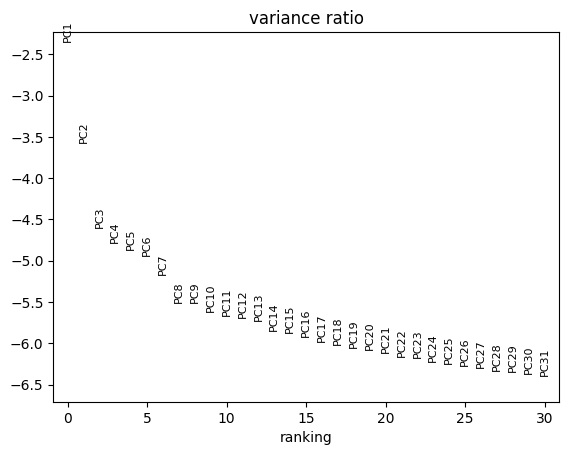

In [8]:
print("Performing PCA...")
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [9]:
print("Computing neighbors...")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=8)  # I set n_pcs to 8 after
                                                  # after viewing the PCA plot
                                                  # and finding the elbow

Computing neighbors...


In [10]:
print("Louvain clustering...")
sc.tl.leiden(
    adata, resolution=0.2, flavor="igraph", n_iterations=2, directed=False
)

Louvain clustering...


Computing UMAP...


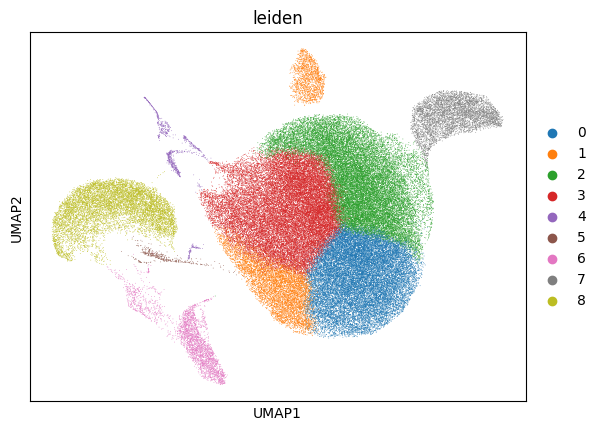

In [11]:
print("Computing UMAP...")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden"])

In [12]:
# print("Ranking genes...")
# sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
# sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

Running DBSCAN with PCA embeddings...
Running 2D grid search with 15 eps values and 13 min_samples values...


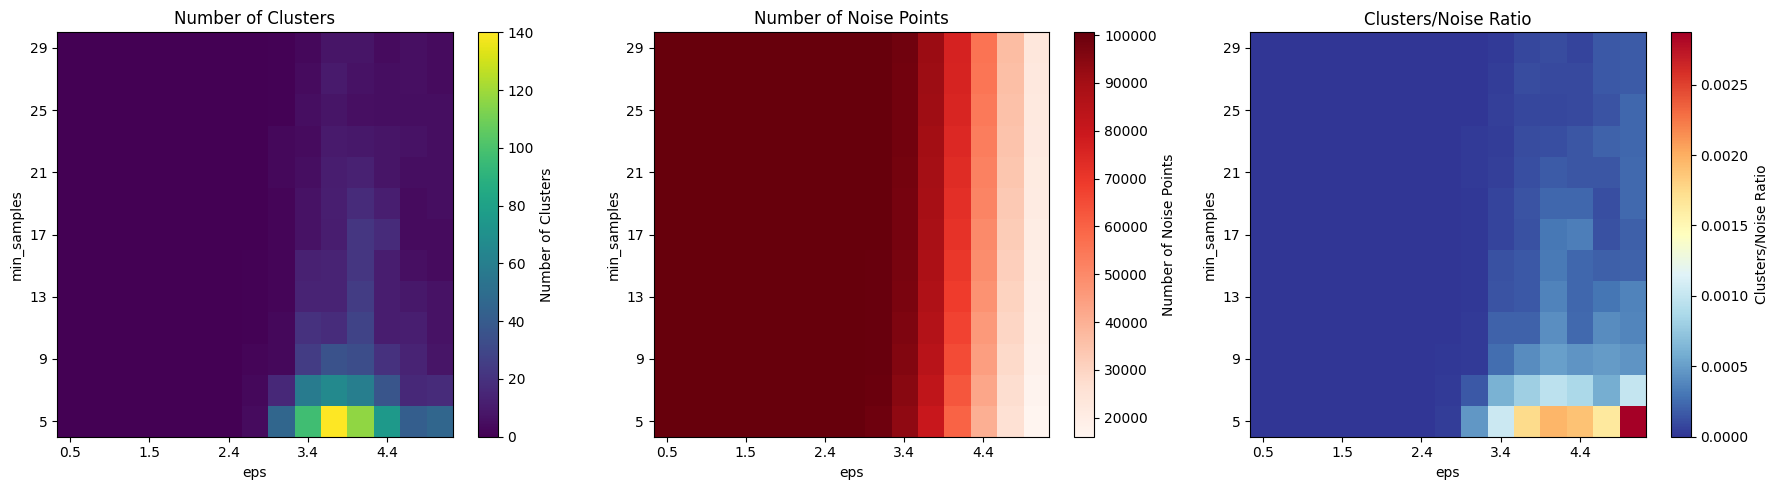


Optimal parameters (based on clusters/noise ratio):
eps: 5.00
min_samples: 5
Number of clusters: 46
Number of noise points: 16023

Running DBSCAN with optimal parameters...


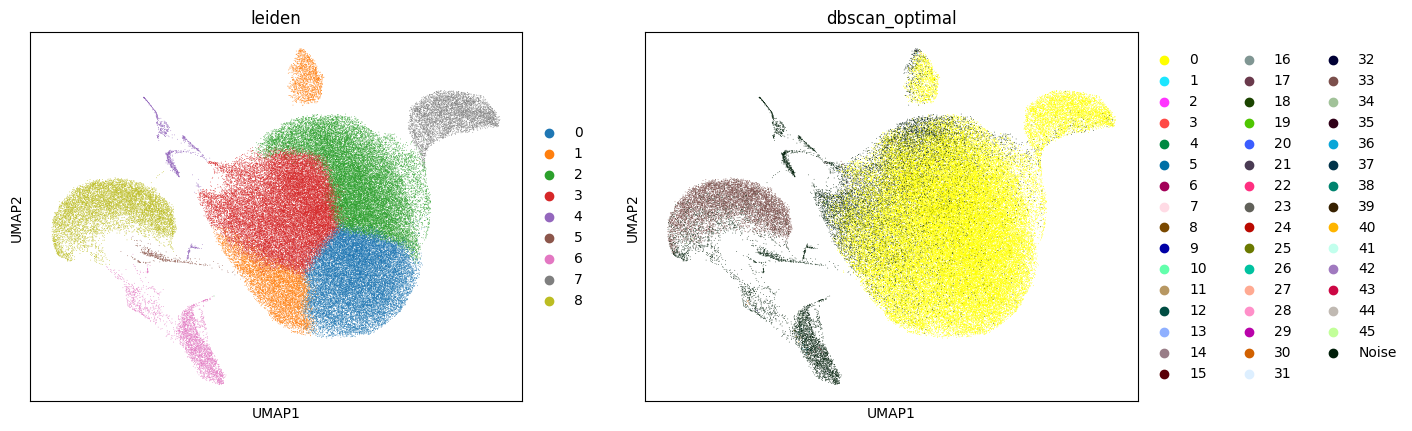

In [24]:
print("Running DBSCAN with PCA embeddings...")


embedding = adata.obsm["X_pca"][:, :30]

eps_values = np.linspace(0.5, 5, 15)
min_pts_values = np.arange(5, 31, 2)

print(
    f"Running 2D grid search with {len(eps_values)} eps values and "
    f"{len(min_pts_values)} min_samples values..."
)

n_clusters_matrix = np.zeros((len(min_pts_values), len(eps_values)))
n_noise_matrix = np.zeros((len(min_pts_values), len(eps_values)))

for i, min_pts in enumerate(min_pts_values):
    for j, eps in enumerate(eps_values):
        db = DBSCAN(eps=eps, min_samples=min_pts).fit(embedding)
        labels = db.labels_

        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)

        n_clusters_matrix[i, j] = n_clusters
        n_noise_matrix[i, j] = n_noise

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

im1 = axes[0].imshow(
    n_clusters_matrix, cmap="viridis", aspect="auto", origin="lower"
)
axes[0].set_xlabel("eps")
axes[0].set_ylabel("min_samples")
axes[0].set_title("Number of Clusters")

eps_tick_indices = np.arange(
    0, len(eps_values), max(1, len(eps_values)//5)
)
min_pts_tick_indices = np.arange(
    0, len(min_pts_values), max(1, len(min_pts_values)//5)
)

axes[0].set_xticks(eps_tick_indices)
axes[0].set_xticklabels([f'{eps_values[i]:.1f}' for i in eps_tick_indices])
axes[0].set_yticks(min_pts_tick_indices)
axes[0].set_yticklabels([f'{min_pts_values[i]}' for i in min_pts_tick_indices])

plt.colorbar(im1, ax=axes[0], label="Number of Clusters")

im2 = axes[1].imshow(n_noise_matrix, cmap="Reds", aspect="auto", origin="lower")
axes[1].set_xlabel("eps")
axes[1].set_ylabel("min_samples")
axes[1].set_title("Number of Noise Points")

axes[1].set_xticks(eps_tick_indices)
axes[1].set_xticklabels([f'{eps_values[i]:.1f}' for i in eps_tick_indices])
axes[1].set_yticks(min_pts_tick_indices)
axes[1].set_yticklabels([f'{min_pts_values[i]}' for i in min_pts_tick_indices])

plt.colorbar(im2, ax=axes[1], label="Number of Noise Points")

ratio_matrix = n_clusters_matrix / (n_noise_matrix + 1e-10)
im3 = axes[2].imshow(
    ratio_matrix, cmap="RdYlBu_r", aspect="auto", origin="lower"
)
axes[2].set_xlabel("eps")
axes[2].set_ylabel("min_samples")
axes[2].set_title("Clusters/Noise Ratio")

axes[2].set_xticks(eps_tick_indices)
axes[2].set_xticklabels([f'{eps_values[i]:.1f}' for i in eps_tick_indices])
axes[2].set_yticks(min_pts_tick_indices)
axes[2].set_yticklabels([f'{min_pts_values[i]}' for i in min_pts_tick_indices])

plt.colorbar(im3, ax=axes[2], label="Clusters/Noise Ratio")

plt.tight_layout()
plt.show()

# Find and print optimal parameters
best_idx = np.unravel_index(np.argmax(ratio_matrix), ratio_matrix.shape)
best_min_pts = min_pts_values[best_idx[0]]
best_eps = eps_values[best_idx[1]]
best_n_clusters = n_clusters_matrix[best_idx[0], best_idx[1]]
best_n_noise = n_noise_matrix[best_idx[0], best_idx[1]]

print(f"\nOptimal parameters (based on clusters/noise ratio):")
print(f"eps: {best_eps:.2f}")
print(f"min_samples: {best_min_pts}")
print(f"Number of clusters: {int(best_n_clusters)}")
print(f"Number of noise points: {int(best_n_noise)}")

print("\nRunning DBSCAN with optimal parameters...")
db_optimal = DBSCAN(eps=best_eps, min_samples=best_min_pts).fit(embedding)
adata.obs["dbscan_optimal"] = db_optimal.labels_.astype(str)

# Convert -1 (noise) to a more descriptive label
adata.obs["dbscan_optimal"] = adata.obs["dbscan_optimal"].replace("-1", "Noise")

sc.pl.umap(adata, color=["leiden", "dbscan_optimal"], ncols=2)



Finding highly variable genes...
Scaling data...


/usr/lib/python3.12/functools.py:909: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


Performing PCA...


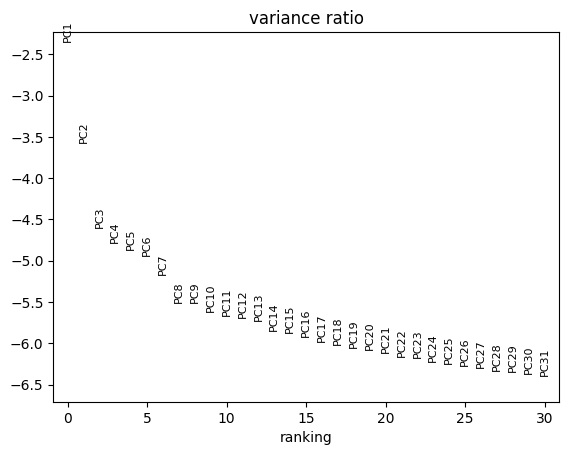

Computing neighbors...
Louvain clustering...
Computing UMAP...


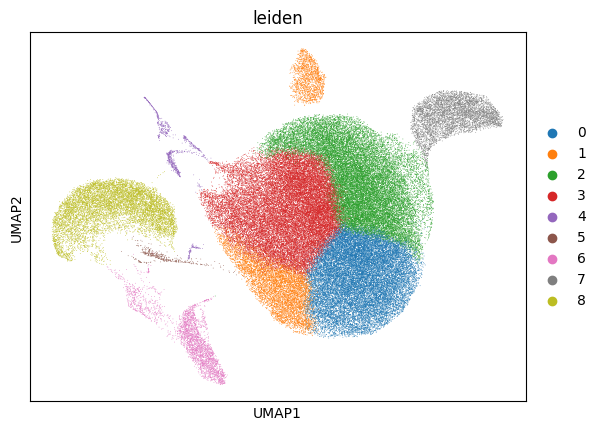

Running 2D grid search with 15 eps values and 13 min_samples values...


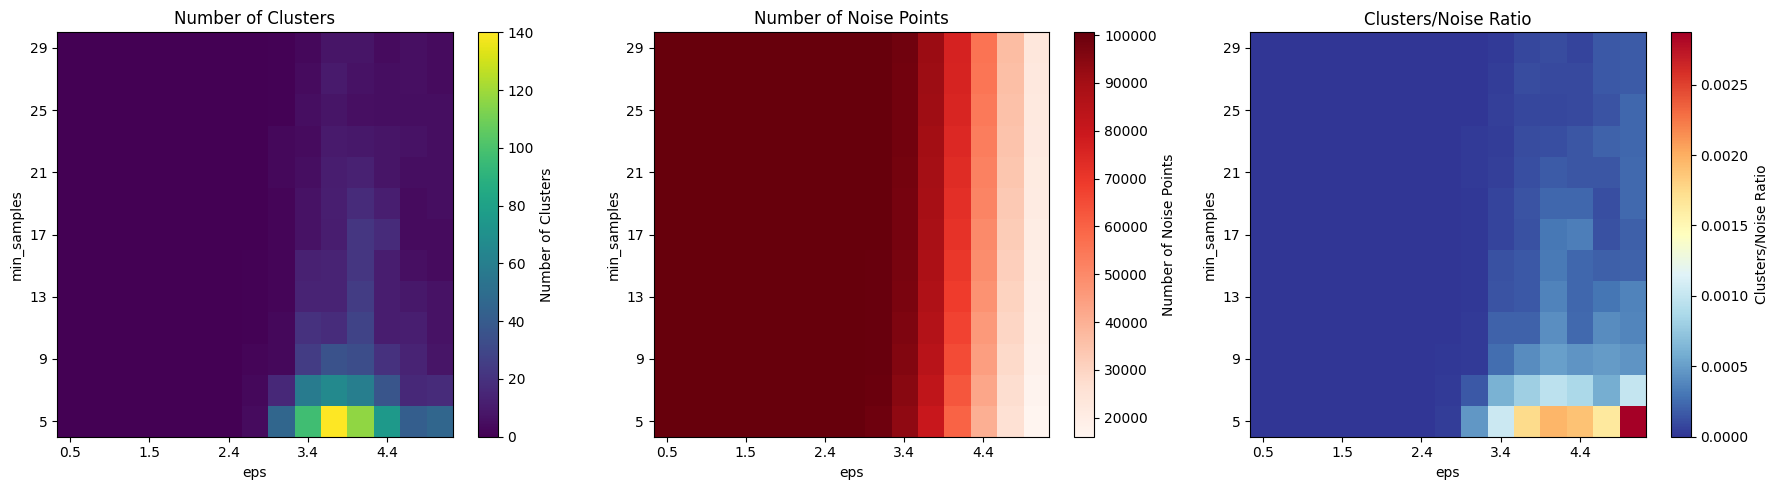


Optimal parameters (based on clusters/noise ratio):
eps: 5.00
min_samples: 5
Number of clusters: 46
Number of noise points: 16023

Filtering noise points with optimal DBSCAN parameters...
Removed 16023 noise points out of 100562 total cells
Retained 84539 cells for Leiden clustering
Recomputing neighbors on filtered data...
Running Leiden clustering on noise-filtered data...
Computing UMAP on filtered data...


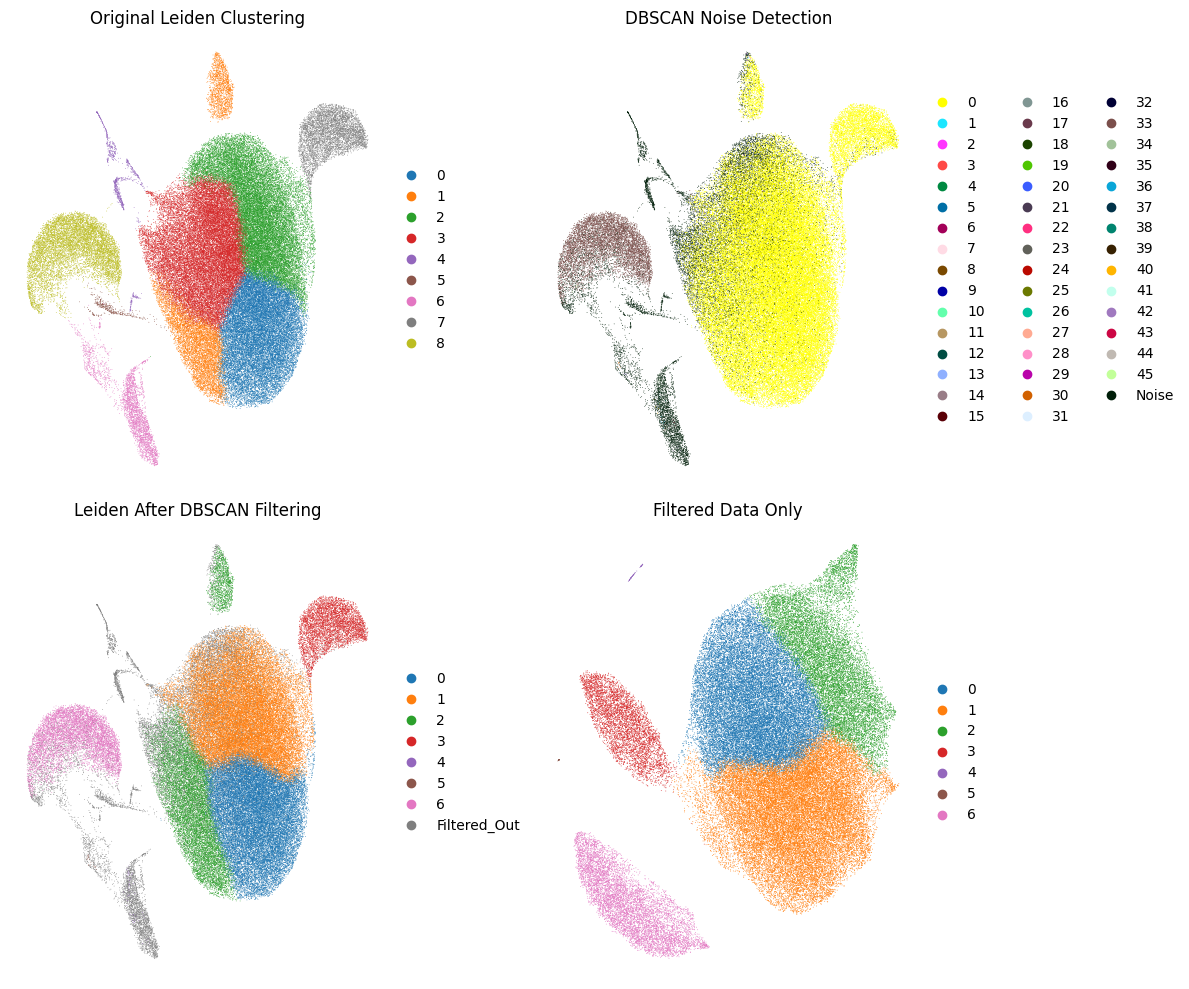


Clustering Statistics:
Original Leiden clusters: 9
DBSCAN removed points: 16023
Leiden clusters after filtering: 7

Original Leiden cluster sizes:
leiden
0    21928
1     8512
2    24339
3    27398
4      932
5      374
6     3088
7     5121
8     8870
Name: count, dtype: int64

Filtered Leiden cluster sizes:
leiden
0    26268
1    32034
2    13611
3     5027
4       76
5       22
6     7501
Name: count, dtype: int64


In [26]:
adata = hy_v2.to_memory()

print("Finding highly variable genes...")
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor="seurat")
adata = adata[:, adata.var.highly_variable].copy()

print("Scaling data...")
sc.pp.scale(adata, max_value=10)

print("Performing PCA...")
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

print("Computing neighbors...")
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=8)  # I set n_pcs to 8 after
                                                  # after viewing the PCA plot
                                                  # and finding the elbow

print("Louvain clustering...")
sc.tl.leiden(
    adata, resolution=0.2, flavor="igraph", n_iterations=2, directed=False
)

print("Computing UMAP...")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden"])

embedding = adata.obsm["X_pca"][:, :30]

# 2D Grid search parameters
eps_values = np.linspace(0.5, 5, 15)
min_pts_values = np.arange(5, 31, 2)  # 5 to 30 in steps of 2

print(f"Running 2D grid search with {len(eps_values)} eps values and {len(min_pts_values)} min_samples values...")

# Initialize result matrices
n_clusters_matrix = np.zeros((len(min_pts_values), len(eps_values)))
n_noise_matrix = np.zeros((len(min_pts_values), len(eps_values)))

# Perform grid search
for i, min_pts in enumerate(min_pts_values):
    for j, eps in enumerate(eps_values):
        db = DBSCAN(eps=eps, min_samples=min_pts).fit(embedding)
        labels = db.labels_
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        n_clusters_matrix[i, j] = n_clusters
        n_noise_matrix[i, j] = n_noise

# Create 2D heatmap visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Number of clusters heatmap
im1 = axes[0].imshow(n_clusters_matrix, cmap='viridis', aspect='auto', origin='lower')
axes[0].set_xlabel('eps')
axes[0].set_ylabel('min_samples')
axes[0].set_title('Number of Clusters')

# Set tick labels
eps_tick_indices = np.arange(0, len(eps_values), max(1, len(eps_values)//5))
min_pts_tick_indices = np.arange(0, len(min_pts_values), max(1, len(min_pts_values)//5))

axes[0].set_xticks(eps_tick_indices)
axes[0].set_xticklabels([f'{eps_values[i]:.1f}' for i in eps_tick_indices])
axes[0].set_yticks(min_pts_tick_indices)
axes[0].set_yticklabels([f'{min_pts_values[i]}' for i in min_pts_tick_indices])

plt.colorbar(im1, ax=axes[0], label='Number of Clusters')

# Plot 2: Number of noise points heatmap
im2 = axes[1].imshow(n_noise_matrix, cmap='Reds', aspect='auto', origin='lower')
axes[1].set_xlabel('eps')
axes[1].set_ylabel('min_samples')
axes[1].set_title('Number of Noise Points')

axes[1].set_xticks(eps_tick_indices)
axes[1].set_xticklabels([f'{eps_values[i]:.1f}' for i in eps_tick_indices])
axes[1].set_yticks(min_pts_tick_indices)
axes[1].set_yticklabels([f'{min_pts_values[i]}' for i in min_pts_tick_indices])

plt.colorbar(im2, ax=axes[1], label='Number of Noise Points')

# Plot 3: Ratio of clusters to noise (quality metric)
# Avoid division by zero by adding small epsilon
ratio_matrix = n_clusters_matrix / (n_noise_matrix + 1e-10)
im3 = axes[2].imshow(ratio_matrix, cmap='RdYlBu_r', aspect='auto', origin='lower')
axes[2].set_xlabel('eps')
axes[2].set_ylabel('min_samples')
axes[2].set_title('Clusters/Noise Ratio')

axes[2].set_xticks(eps_tick_indices)
axes[2].set_xticklabels([f'{eps_values[i]:.1f}' for i in eps_tick_indices])
axes[2].set_yticks(min_pts_tick_indices)
axes[2].set_yticklabels([f'{min_pts_values[i]}' for i in min_pts_tick_indices])

plt.colorbar(im3, ax=axes[2], label='Clusters/Noise Ratio')

plt.tight_layout()
plt.show()

# Find and print optimal parameters
# You can adjust this criterion based on your preferences
best_idx = np.unravel_index(np.argmax(ratio_matrix), ratio_matrix.shape)
best_min_pts = min_pts_values[best_idx[0]]
best_eps = eps_values[best_idx[1]]
best_n_clusters = n_clusters_matrix[best_idx[0], best_idx[1]]
best_n_noise = n_noise_matrix[best_idx[0], best_idx[1]]

print(f"\nOptimal parameters (based on clusters/noise ratio):")
print(f"eps: {best_eps:.2f}")
print(f"min_samples: {best_min_pts}")
print(f"Number of clusters: {int(best_n_clusters)}")
print(f"Number of noise points: {int(best_n_noise)}")

# Use DBSCAN to filter noise points and then run Leiden
print("\nFiltering noise points with optimal DBSCAN parameters...")
db_optimal = DBSCAN(eps=best_eps, min_samples=best_min_pts).fit(embedding)

# Identify non-noise points (labels != -1)
non_noise_mask = db_optimal.labels_ != -1
print(f"Removed {(~non_noise_mask).sum()} noise points out of {len(adata)} total cells")
print(f"Retained {non_noise_mask.sum()} cells for Leiden clustering")

# Create filtered dataset without noise points
adata_filtered = adata[non_noise_mask].copy()

# Store original DBSCAN labels for reference
adata.obs['dbscan_labels'] = db_optimal.labels_.astype(str)
adata.obs['dbscan_labels'] = adata.obs['dbscan_labels'].replace('-1', 'Noise')

# Recompute neighbors on filtered data (important!)
print("Recomputing neighbors on filtered data...")
sc.pp.neighbors(adata_filtered, n_neighbors=15, n_pcs=8)

# Run Leiden clustering on filtered data
print("Running Leiden clustering on noise-filtered data...")
sc.tl.leiden(
    adata_filtered, resolution=0.2, flavor="igraph", n_iterations=2, directed=False
)

# Recompute UMAP on filtered data
print("Computing UMAP on filtered data...")
sc.tl.umap(adata_filtered)

# Transfer results back to original adata object
# Initialize with 'Filtered_Out' for noise points
adata.obs['leiden_after_dbscan'] = 'Filtered_Out'
# Fill in Leiden labels for non-noise points
adata.obs.loc[non_noise_mask, 'leiden_after_dbscan'] = adata_filtered.obs['leiden'].values

# Transfer filtered UMAP coordinates
adata.obsm['X_umap_filtered'] = np.full((adata.n_obs, 2), np.nan)
adata.obsm['X_umap_filtered'][non_noise_mask] = adata_filtered.obsm['X_umap']

# Visualization comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original Leiden clustering
sc.pl.umap(adata, color='leiden', ax=axes[0,0], show=False, frameon=False)
axes[0,0].set_title('Original Leiden Clustering')

# DBSCAN noise detection
sc.pl.umap(adata, color='dbscan_labels', ax=axes[0,1], show=False, frameon=False)
axes[0,1].set_title('DBSCAN Noise Detection')

# Leiden after DBSCAN filtering
sc.pl.umap(adata, color='leiden_after_dbscan', ax=axes[1,0], show=False, frameon=False)
axes[1,0].set_title('Leiden After DBSCAN Filtering')

# Filtered data UMAP (without noise points)
# Clear any existing palette to avoid conflicts
if 'leiden_colors' in adata_filtered.uns:
    del adata_filtered.uns['leiden_colors']

# Plot filtered data with automatic palette generation
sc.pl.umap(adata_filtered, color='leiden', ax=axes[1,1], show=False, frameon=False)
axes[1,1].set_title('Filtered Data Only')

plt.tight_layout()
plt.show()

# Print clustering statistics
print(f"\nClustering Statistics:")
print(f"Original Leiden clusters: {len(adata.obs['leiden'].unique())}")
print(f"DBSCAN removed points: {(~non_noise_mask).sum()}")
print(f"Leiden clusters after filtering: {len(adata_filtered.obs['leiden'].unique())}")

# Show cluster size comparison
print(f"\nOriginal Leiden cluster sizes:")
print(adata.obs['leiden'].value_counts().sort_index())
print(f"\nFiltered Leiden cluster sizes:")
print(adata_filtered.obs['leiden'].value_counts().sort_index())